In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from pyro.contrib.autoguide import AutoLowRankMultivariateNormal

In [3]:
from scipy.stats import multivariate_normal

In [4]:
N, D = 1000, 10
random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
random_data = multivariate_normal(cov=random_covariance).rvs(size=N)

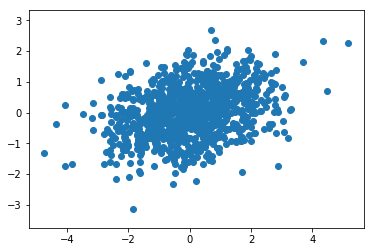

In [5]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [6]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(random_covariance_factor)
print(random_covariance)
print(np.cov(random_data.T))

[[0.00 0.00 0.00 0.00 0.27 0.00 0.43 0.78 0.81 0.45]
 [0.00 0.00 0.96 0.34 0.21 0.28 0.28 0.00 0.11 0.16]
 [0.88 0.53 0.73 0.00 0.59 0.91 0.00 0.17 0.28 0.33]
 [0.00 0.15 0.73 0.00 0.00 0.00 0.21 0.27 0.00 0.00]
 [0.00 0.00 0.19 0.46 0.09 0.00 0.00 0.00 0.00 0.00]
 [0.82 0.00 0.00 0.00 0.00 0.09 0.00 0.35 0.00 0.00]
 [0.04 0.51 0.73 0.98 0.00 0.65 0.64 0.47 0.00 0.00]
 [0.77 0.51 0.97 0.00 0.35 0.34 0.87 0.00 0.00 0.91]
 [0.00 0.00 0.37 0.62 0.00 0.63 0.00 0.00 0.00 0.81]
 [0.07 0.00 0.00 0.10 0.42 0.00 0.65 0.20 0.00 0.00]]
[[1.72 0.34 0.67 0.30 0.03 0.27 0.64 0.87 0.36 0.55]
 [0.34 1.28 1.17 0.77 0.36 0.03 1.40 1.48 0.87 0.30]
 [0.67 1.17 2.98 0.66 0.20 0.86 1.51 2.48 1.12 0.35]
 [0.30 0.77 0.66 0.68 0.14 0.10 0.88 0.98 0.27 0.19]
 [0.03 0.36 0.20 0.14 0.26 0.00 0.59 0.22 0.36 0.09]
 [0.27 0.03 0.86 0.10 0.00 0.80 0.26 0.67 0.06 0.13]
 [0.64 1.40 1.51 0.88 0.59 0.26 2.79 1.77 1.28 0.62]
 [0.87 1.48 2.48 0.98 0.22 0.67 1.77 3.62 1.31 0.77]
 [0.36 0.87 1.12 0.27 0.36 0.06 1.28 1.31 1.5

In [7]:
data = torch.tensor(random_data,dtype=torch.float32)

In [8]:
#pyro.distributions.AVFMultivariateNormal

In [9]:
#torch.cholesky(torch.matmul(cov_factor,cov_factor.transpose(0,1)))

In [10]:
def factorAnalysis(data):
    N, D = data.shape
    loc = pyro.sample('loc',dst.Normal(torch.zeros(D),10.).to_event(1))
    cov_factor = torch.zeros((D,D))
    with pyro.plate('feature_plate', D) as feature:
        cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(torch.zeros(D),10.).to_event(1))
        cov_factor[:,feature] = cov_factor_column
    #cov_factor = pyro.sample('cov_factor',dst.Normal(torch.zeros((D,D)),10.))
    cov_diag = pyro.sample('cov_diag', dst.LogNormal(torch.zeros(D),4.).to_event(1))
    with pyro.plate('data', N):
        data = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return data

In [11]:
observedFactorAnalysis = pyro.condition(factorAnalysis, data = {'obs': data})

In [12]:
observedFactorAnalysis(data)

tensor([[-2.0192,  0.0251, -0.2236,  ...,  0.2366,  0.8216, -1.2406],
        [ 0.7909,  1.8381,  2.7391,  ...,  3.6358,  1.9439,  0.7321],
        [ 0.6611,  0.7027,  2.1189,  ...,  2.6769,  1.2226,  0.0412],
        ...,
        [ 0.1507, -0.6698, -1.0035,  ...,  0.9563,  0.7515,  0.5174],
        [-1.3206,  0.4863, -1.2239,  ...,  0.2266,  0.5199, -0.1946],
        [-1.3700, -1.3766,  0.8692,  ..., -0.8677, -1.8915,  0.2192]])

In [13]:
#guide = AutoLowRankMultivariateNormal(poutine.block(factorAnalysis,expose=['loc','cov_factor','cov_diag']))

In [14]:
def factorAnalysisGuide(data):
    N, D = data.shape
    K = D
    loc_mean = pyro.param('loc_mean', torch.zeros(D, requires_grad = False))
    loc_scale = pyro.param('loc_scale', torch.ones(D), constraint=constraints.positive)
    # in the model, cov_factor_columns share the mean and variance
    # in the guide, each column has its own
    cov_factor_mean = pyro.param('cov_factor_mean', torch.zeros(D,K))
    cov_factor_scale = pyro.param('cov_factor_scale', torch.ones(D,K), constraint=constraints.positive)
    cov_diag_mean = pyro.param('cov_diag_mean', torch.zeros(D))
    cov_diag_scale = pyro.param('cov_diag_scale', torch.ones(D), constraint=constraints.positive)
    loc = pyro.sample('loc', dst.Normal(loc_mean,loc_scale).to_event(1))
    cov_factor = torch.zeros((D,D))
    with pyro.plate('feature_plate', D) as feature:
        cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(cov_factor_mean, cov_factor_scale).to_event(1))
        cov_factor[:,feature] = cov_factor_column
    cov_diag = pyro.sample('cov_diag', dst.LogNormal(cov_diag_mean, cov_diag_scale).to_event(1))
    return loc, cov_factor, cov_diag

In [15]:
#pyro.clear_param_store()
trace = pyro.poutine.trace(observedFactorAnalysis).get_trace(data)
guide_trace = pyro.poutine.trace(factorAnalysisGuide).get_trace(data)
pyro.util.check_model_guide_match(trace, guide_trace)
print(pyro.get_param_store().named_parameters(),sep='\n')

dict_items([('loc_mean', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('loc_scale', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('cov_factor_mean', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)), ('cov_factor_scale', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

In [16]:
#optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
#optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
#optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
#optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.99]})
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO()
svi = SVI(observedFactorAnalysis, factorAnalysisGuide, optim, loss=elbo)

In [17]:
def initialize(seed):
    # evaluate loss on a randomly initialized parameter-set 
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # guide param names were defined by AutoDelta, with names copied from model and prefixed by 'auto_'
    # Initialize means to a single sample of data.
    #pyro.param('auto_loc', data[torch.multinomial(torch.ones(len(data)) / len(data), 1)]);
    #pyro.param('auto_scale', (data.var(0) / 2).sqrt(), constraint=constraints.positive)
    # WHY DO I GET AN ERROR WHEN USING PYRO.CONDITION?
    #loss = svi.loss(cond_model, global_guide, data)
    loss = svi.loss(factorAnalysis, guide, data)
    return loss

In [18]:
# Choose the best among 100 random initializations.
#loss, seed = min((initialize(seed), seed) for seed in range(100))
#initialize(seed)
#print('seed = {}, initial_loss = {}'.format(seed, loss))

In [19]:
pyro.get_param_store().named_parameters()

dict_items([('loc_mean', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('loc_scale', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)), ('cov_factor_mean', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)), ('cov_factor_scale', tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     

In [20]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

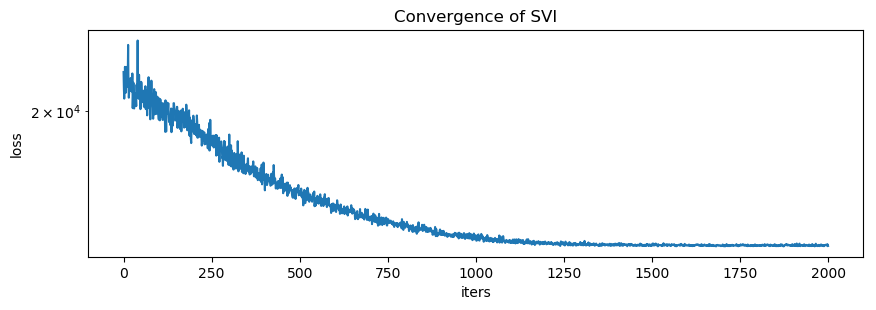

In [21]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [22]:
for name, node in trace.nodes.items():
    print(name,node["type"])

_INPUT args
loc sample
feature_plate sample
cov_factor_column sample
cov_diag sample
data sample
obs sample
_RETURN return


In [23]:
for name, node in guide_trace.nodes.items():
    print(node["type"])

args
param
param
param
param
param
param
sample
sample
sample
sample
return


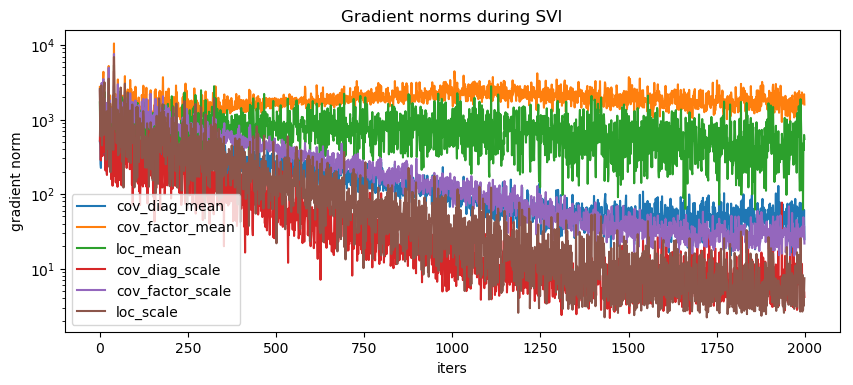

In [24]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [25]:
dict(pyro.get_param_store())

{'loc_mean': tensor([ 0.0043,  0.0025,  0.0163,  0.0326, -0.0354,  0.0145, -0.0439,  0.0458,
         -0.0753,  0.0141], requires_grad=True),
 'loc_scale': tensor([0.0249, 0.0098, 0.0238, 0.0073, 0.0073, 0.0174, 0.0184, 0.0250, 0.0148,
         0.0128], grad_fn=<AddBackward0>),
 'cov_factor_mean': tensor([[ 7.1330e-01, -4.6265e-02, -2.6003e-01,  2.7365e-01,  7.9321e-03,
          -1.9731e-01,  3.5543e-01,  7.3465e-01,  2.2455e-02, -2.6612e-01],
         [ 1.2814e-01, -3.1026e-02, -6.7349e-01,  6.3152e-01, -1.1010e-02,
          -2.5155e-01, -5.3826e-01,  1.3517e-01, -8.9167e-02, -8.4118e-02],
         [-3.9852e-02, -4.4853e-02, -6.2049e-01, -4.6551e-02, -1.1900e-02,
          -2.3703e-01, -6.7419e-01,  5.6216e-01, -8.7065e-01, -9.2867e-01],
         [ 9.4311e-02, -1.6224e-02, -1.8903e-01,  6.9243e-01, -7.8611e-03,
           7.9774e-03, -2.6303e-01,  1.4156e-01, -1.3059e-01, -1.6721e-01],
         [ 5.4840e-02,  7.4356e-04, -3.0441e-01,  1.3152e-01, -9.4658e-03,
          -2.1581e-01, 

In [26]:
cov_factor_est = pyro.get_param_store()['cov_factor_mean']

In [27]:
# mode of lognormal is exp(mu - sigma^2)
cov_diag_est = torch.exp(pyro.get_param_store()['cov_diag_mean'] - pyro.get_param_store()['cov_diag_scale']**2)

In [28]:
total_cov_est = torch.matmul(cov_factor_est,cov_factor_est.transpose(0,1)) + torch.diag(cov_diag_est)

In [29]:
total_cov_est

tensor([[ 1.8376,  0.4187,  0.5699,  0.3571,  0.0279,  0.2314,  0.6588,  0.9145,
          0.3369,  0.6621],
        [ 0.4187,  1.2604,  1.0392,  0.7617,  0.3406,  0.0141,  1.3203,  1.4711,
          0.7849,  0.3891],
        [ 0.5699,  1.0392,  2.8890,  0.6061,  0.1667,  0.9285,  1.3024,  2.3773,
          1.0302,  0.3402],
        [ 0.3571,  0.7617,  0.6061,  0.6614,  0.1340,  0.0994,  0.8486,  0.9944,
          0.2169,  0.2483],
        [ 0.0279,  0.3406,  0.1667,  0.1340,  0.2382, -0.0059,  0.5447,  0.1997,
          0.3062,  0.1153],
        [ 0.2314,  0.0141,  0.9285,  0.0994, -0.0059,  0.8461,  0.2650,  0.7145,
          0.0643,  0.1422],
        [ 0.6588,  1.3203,  1.3024,  0.8486,  0.5447,  0.2650,  2.7213,  1.7320,
          1.1242,  0.7294],
        [ 0.9145,  1.4711,  2.3773,  0.9944,  0.1997,  0.7145,  1.7320,  3.7494,
          1.2161,  0.9225],
        [ 0.3369,  0.7849,  1.0302,  0.2169,  0.3062,  0.0643,  1.1242,  1.2161,
          1.4648,  0.1208],
        [ 0.6621,  

In [30]:
random_covariance

array([[1.72, 0.34, 0.67, 0.30, 0.03, 0.27, 0.64, 0.87, 0.36, 0.55],
       [0.34, 1.28, 1.17, 0.77, 0.36, 0.03, 1.40, 1.48, 0.87, 0.30],
       [0.67, 1.17, 2.98, 0.66, 0.20, 0.86, 1.51, 2.48, 1.12, 0.35],
       [0.30, 0.77, 0.66, 0.68, 0.14, 0.10, 0.88, 0.98, 0.27, 0.19],
       [0.03, 0.36, 0.20, 0.14, 0.26, 0.00, 0.59, 0.22, 0.36, 0.09],
       [0.27, 0.03, 0.86, 0.10, 0.00, 0.80, 0.26, 0.67, 0.06, 0.13],
       [0.64, 1.40, 1.51, 0.88, 0.59, 0.26, 2.79, 1.77, 1.28, 0.62],
       [0.87, 1.48, 2.48, 0.98, 0.22, 0.67, 1.77, 3.62, 1.31, 0.77],
       [0.36, 0.87, 1.12, 0.27, 0.36, 0.06, 1.28, 1.31, 1.58, 0.06],
       [0.55, 0.30, 0.35, 0.19, 0.09, 0.13, 0.62, 0.77, 0.06, 0.66]])

In [31]:
rel_err(random_covariance, total_cov_est)

tensor(0.0734, grad_fn=<DivBackward0>)

In [32]:
sample_sites = []
for name, node in trace.nodes.items():
    if node['type'] is 'sample' and not node['is_observed']:
        sample_sites.append(node)

In [33]:
variatonal_posterior_sample = dict(zip(['loc','cov_factor_column','cov_diag'],factorAnalysisGuide(data)))

In [34]:
posterior_predictive = pyro.condition(factorAnalysis, data = variatonal_posterior_sample)

In [41]:
posterior_predictive_check = posterior_predictive(data)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

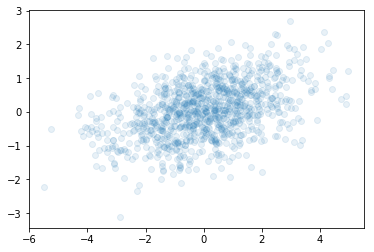

In [44]:
# plot two random dimensions against each other
random_idxs = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idxs].T, alpha=.1)
pyplot.scatter(*posterior_predictive_check[:,random_idxs].transpose(0,1), alpha=.1)
pyplot.axis('equal');

In [36]:
std_normal = pyro.distributions.Normal(loc=0,scale=1)

In [37]:
std_normal.entropy(),np.log2(np.exp(1))*std_normal.entropy()

(tensor(1.4189), tensor(2.0471))

In [38]:
bern = pyro.distributions.Bernoulli(probs=0.5)

In [39]:
np.log2(np.exp(1))*bern.entropy()

tensor(1.)